# Data Preprocessing

This notebook will combine the raw data from individual flight logs. There are four different drone models (all multirotors). Any missing data will be filled with 0 value. The dataframe will be concatenated for all models and then exported as 'fulldata.csv'.

1. DJI Matrice 100 (Open source dataset)
2. DJI Matrice 600
3. DJI Inspire 1 
4. DJI Mavic Pro

The kinematic state of the drone will be expressed in the environment frame (North-East-Down coordinate system). The direction of x-axis is towards North, y-axis towards East and z-axis is towards the center of Earth. The z-axis is negative in the direction of increasing altitude. 

The key information to be extracted from the flight logs are (total columns = 30):

1. longitude, latitutde `long`, `lat`
2. altitude (above mean sea level) `alt`
3. ground velocity in NED `v_N`, `v_E`, `v_D`
4. ground acceleration in NED `a_N`, `a_E`, `a_D`
5. orientation in body frame `phi`, `theta`, `psi`
6. angular velocity in body frame `angular_x`, `angular_y`, `angular_z`
7. wind speed and angle `wind_speed`, `wind_angle`, `wind_N`, `wind_E`
8. battery current, voltage and power `battery_current`, `battery_voltage`, `battery_power`
9. payload and total mass `payload`, `total_mass`
10. drone type `drone_type`
11. reference flight number `flight`
12. flight time `time`

Other columns from open source data, for data exploration:

12. commanded speed `speed`
13. commanded altitude `altitude`
14. route category`route` which includes information about which flights are hover tests

In [1]:
### PACKAGES IMPORTS ###
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.ndimage.filters import uniform_filter1d, median_filter

### INCLUDE GRAPHS IN NOTEBOOK AUTOMATICALLY ###
%matplotlib inline 
from IPython.display import display, Latex
print_col = ["time", "flight", "v_N", "v_E", "v_D", "a_N", "a_E", "a_D" ,"battery_power"]

The `plotflight` function creates plot 1D time graphs of variable for a particular flight. This function is used to check the result of the preprocessing steps visually.

In [2]:
def plotflight(dataframe, flightno, param, min_t=0, max_t=-1, filterlabel = '', stats = True):
    """
    This function plots parameter against time for given flight number.
    """
    for flno in flightno:
        plotdata = dataframe.loc[dataframe['flight'] == flno].copy()
        t = plotdata['time'] - float(plotdata['time'].head(n=1))
        for var in param:
            name = plotdata['drone_type'].iloc[0]
            y = plotdata[var]
            plt.plot(t[min_t:max_t], y[min_t:max_t], label =  name + ' flight ' + str(flno) + ', ' + var + filterlabel)
            plt.ylabel(str(var))
            if stats: 
                print(f'{name} flight {flno} {var} mean: {float(y.mean()):.2f}')
                print(f'{name} flight {flno} {var} std: {float(y.std()):.2f}')
        plt.xlabel('Time')
    plt.legend()

## Matrice 100 - Open source data 

Basic information from [source](https://www.nature.com/articles/s41597-021-00930-x):

1. Total mass of drone is 3.680kg, plus test payloads of {0.0, 0.25, 0.5, 0.75}kg 
2. Data frequency for IMU, GPS and battery is 10Hz, 10Hz and 5Hz respectively.

### Import Data

In [3]:
#load csv file
raw_data = pd.read_csv('C:/Users/nghj7/Desktop/Flight data/Open Source/flights.csv');
#create dataframe
df_m100 = pd.DataFrame(raw_data);
#add total mass column
df_m100['total_mass'] = df_m100['payload']/1000 + 3.680;
#add name of drone
df_m100['drone_type'] = 'matrice_100';
#display(Latex(df_m100.head(n=2).to_latex()))
print('Shape of M100 data: ', df_m100.shape)
df_m100.head(n=5)

Shape of M100 data:  (257896, 30)


c:\users\nghj7\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3169: DtypeWarning: Columns (24) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,flight,time,wind_speed,wind_angle,battery_voltage,battery_current,position_x,position_y,position_z,orientation_x,...,linear_acceleration_y,linear_acceleration_z,speed,payload,altitude,date,time_day,route,total_mass,drone_type
0,1,0.0,0.1,12,24.222174,0.087470,-79.782396,40.458047,269.332402,0.001772,...,-0.120405,-9.811137,4,0,25,4/7/2019,10:13,R5,3.68,matrice_100
1,1,0.2,0.1,3,24.227180,0.095421,-79.782396,40.458047,269.332056,0.001768,...,-0.116397,-9.810392,4,0,25,4/7/2019,10:13,R5,3.68,matrice_100
2,1,0.3,0.1,352,24.225929,0.095421,-79.782396,40.458047,269.333081,0.001768,...,-0.128592,-9.809440,4,0,25,4/7/2019,10:13,R5,3.68,matrice_100
3,1,0.5,0.1,354,24.224678,0.095421,-79.782396,40.458047,269.334648,0.001775,...,-0.128271,-9.810159,4,0,25,4/7/2019,10:13,R5,3.68,matrice_100
4,1,0.6,0.1,359,24.210905,0.079518,-79.782396,40.458047,269.336178,0.001775,...,-0.119890,-9.812125,4,0,25,4/7/2019,10:13,R5,3.68,matrice_100


### Coordinate Transformation

Velocity and acceleration are provided in the body frame $v_{x,y,z}$ and $a_{x,y,z}$. However, it is more convenient to express in the environment frame  $v_{N,E,D}$ and $a_{N,E,D}$ as navigation of UAV is normally carried out within local NED coordinates. Apply transformation $v_{N,E,D} = R(q_{w}, q_{x}, q_{y},q_{z}) \bullet v_{x,y,z}$ and $a_{N,E,D} = R(q_{w}, q_{x}, q_{y},q_{z}) \bullet a_{x,y,z}$ using the quaternion rotation matrix. It is more efficient to compute the transformation row by row for the dataframe as compared to using matrix multiplication but results in repetitive lines of codes.

In [4]:
#calculate euler angle (already in radians)
q = ['orientation_w', 'orientation_x', 'orientation_y', 'orientation_z']
df_m100['phi'] = np.arctan2(2*(df_m100[q[0]]*df_m100[q[1]]+df_m100[q[2]]*df_m100[q[3]]), 1-2*(df_m100[q[1]]**2 + df_m100[q[2]]**2))
df_m100['theta'] = np.arcsin(2*(df_m100[q[0]]*df_m100[q[2]]+df_m100[q[3]]*df_m100[q[1]]))
df_m100['psi'] = np.arctan2(2*(df_m100[q[0]]*df_m100[q[3]]+df_m100[q[1]]*df_m100[q[2]]), 1-2*(df_m100[q[2]]**2 + df_m100[q[3]]**2))

#transform velocity
df_m100['v_N']=(1-2*(df_m100[q[2]]**2+df_m100[q[3]]**2))*df_m100['velocity_x'] + \
                     (2*(df_m100[q[1]]*df_m100[q[2]]-df_m100[q[0]]*df_m100[q[3]]))*df_m100['velocity_y'] + \
                     (2*(df_m100[q[1]]*df_m100[q[3]]+df_m100[q[0]]*df_m100[q[2]]))*df_m100['velocity_z']
                    
df_m100['v_E']=(2*(df_m100[q[1]]*df_m100[q[2]]+df_m100[q[0]]*df_m100[q[3]]))*df_m100['velocity_x'] + \
                     (1-2*(df_m100[q[1]]**2+df_m100[q[3]]**2))*df_m100['velocity_y'] + \
                     (2*(df_m100[q[2]]*df_m100[q[3]]-df_m100[q[0]]*df_m100[q[1]]))*df_m100['velocity_z']

df_m100['v_D']=(2*(df_m100[q[1]]*df_m100[q[3]]-df_m100[q[0]]*df_m100[q[2]]))*df_m100['velocity_x'] + \
                     (2*(df_m100[q[2]]*df_m100[q[3]]+df_m100[q[0]]*df_m100[q[1]]))*df_m100['velocity_y'] + \
                     (1-2*(df_m100[q[1]]**2+df_m100[q[2]]**2))*df_m100['velocity_z']

#transform acceleration
df_m100['a_N']=(1-2*(df_m100[q[2]]**2+df_m100[q[3]]**2))*df_m100['linear_acceleration_x'] + \
                     (2*(df_m100[q[1]]*df_m100[q[2]]-df_m100[q[0]]*df_m100[q[3]]))*df_m100['linear_acceleration_y'] + \
                     (2*(df_m100[q[1]]*df_m100[q[3]]+df_m100[q[0]]*df_m100[q[2]]))*df_m100['linear_acceleration_z']
                    
df_m100['a_E']=(2*(df_m100[q[1]]*df_m100[q[2]]+df_m100[q[0]]*df_m100[q[3]]))*df_m100['linear_acceleration_x'] + \
                     (1-2*(df_m100[q[1]]**2+df_m100[q[3]]**2))*df_m100['linear_acceleration_y'] + \
                     (2*(df_m100[q[2]]*df_m100[q[3]]-df_m100[q[0]]*df_m100[q[1]]))*df_m100['linear_acceleration_z']

df_m100['a_D']=(2*(df_m100[q[1]]*df_m100[q[3]]-df_m100[q[0]]*df_m100[q[2]]))*df_m100['linear_acceleration_x'] + \
                     (2*(df_m100[q[2]]*df_m100[q[3]]+df_m100[q[0]]*df_m100[q[1]]))*df_m100['linear_acceleration_y'] + \
                     (1-2*(df_m100[q[1]]**2+df_m100[q[2]]**2))*df_m100['linear_acceleration_z']

### Checking Coordinate Transformation

To check whether the transformation above is done correctly, convert quaternion to Euler angles [(Wikipedia)](https://en.wikipedia.org/wiki/Conversion_between_quaternions_and_Euler_angles). Then, apply transformation $v_{N,E,D} = R(\phi, \theta, \psi) \bullet v_{x,y,z}$ and $a_{N,E,D} = R(\phi, \theta, \psi) \bullet a_{x,y,z}$. Note that there are inaccuracy when transforming quaternion to Euler due to asymptote in arc sine function.

In [5]:
temp_df = df_m100.copy()

#transform velocity
temp_df['Euler_v_N'] = np.cos(temp_df['theta'])*np.cos(temp_df['psi'])*temp_df['velocity_x'] + \
                 (np.sin(temp_df['phi'])*np.sin(temp_df['theta'])*np.cos(temp_df['psi']) - np.cos(temp_df['phi'])*np.sin(temp_df['psi']))*temp_df['velocity_y'] + \
                 (np.cos(temp_df['phi'])*np.sin(temp_df['theta'])*np.cos(temp_df['psi']) + np.sin(temp_df['phi'])*np.sin(temp_df['psi']))*temp_df['velocity_z']

temp_df['Euler_v_E'] = np.cos(temp_df['theta'])*np.sin(temp_df['psi'])*temp_df['velocity_x'] + \
                 (np.sin(temp_df['phi'])*np.sin(temp_df['theta'])*np.sin(temp_df['psi']) + np.cos(temp_df['phi'])*np.cos(temp_df['psi']))*temp_df['velocity_y'] + \
                 (np.cos(temp_df['phi'])*np.sin(temp_df['theta'])*np.sin(temp_df['psi']) - np.sin(temp_df['phi'])*np.cos(temp_df['psi']))*temp_df['velocity_z']

temp_df['Euler_v_D'] = -np.sin(temp_df['theta'])*temp_df['velocity_x'] + \
                 +np.sin(temp_df['phi'])*np.cos(temp_df['theta'])*temp_df['velocity_y'] + \
                 +np.cos(temp_df['phi'])*np.cos(temp_df['theta'])*temp_df['velocity_z']

#transform acceleration
temp_df['Euler_a_N'] = np.cos(temp_df['theta'])*np.cos(temp_df['psi'])*temp_df['linear_acceleration_x'] + \
                 (np.sin(temp_df['phi'])*np.sin(temp_df['theta'])*np.cos(temp_df['psi']) - np.cos(temp_df['phi'])*np.sin(temp_df['psi']))*temp_df['linear_acceleration_y'] + \
                 (np.cos(temp_df['phi'])*np.sin(temp_df['theta'])*np.cos(temp_df['psi']) + np.sin(temp_df['phi'])*np.sin(temp_df['psi']))*temp_df['linear_acceleration_z']

temp_df['Euler_a_E'] = np.cos(temp_df['theta'])*np.sin(temp_df['psi'])*temp_df['linear_acceleration_x'] + \
                 (np.sin(temp_df['phi'])*np.sin(temp_df['theta'])*np.sin(temp_df['psi']) + np.cos(temp_df['phi'])*np.cos(temp_df['psi']))*temp_df['linear_acceleration_y'] + \
                 (np.cos(temp_df['phi'])*np.sin(temp_df['theta'])*np.sin(temp_df['psi']) - np.sin(temp_df['phi'])*np.cos(temp_df['psi']))*temp_df['linear_acceleration_z']

temp_df['Euler_a_D'] = -np.sin(temp_df['theta'])*temp_df['linear_acceleration_x'] + \
                 +np.sin(temp_df['phi'])*np.cos(temp_df['theta'])*temp_df['linear_acceleration_y'] + \
                 +np.cos(temp_df['phi'])*np.cos(temp_df['theta'])*temp_df['linear_acceleration_z']

In [6]:
pd.testing.assert_series_equal(temp_df['Euler_v_D'], df_m100['v_D'], rtol =0, atol = 7, check_names = False)

The maximum error is up to 7m/s for v_D given by the absolute tolerance when asserting the equivalence of both data.

matrice_100 flight 3 Euler_v_D mean: 0.00
matrice_100 flight 3 Euler_v_D std: 0.81
matrice_100 flight 3 v_D mean: 0.02
matrice_100 flight 3 v_D std: 0.73


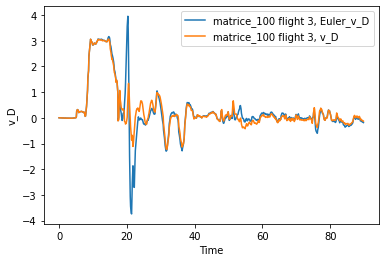

In [7]:
plotflight(temp_df, [3], ['Euler_v_D'], min_t=0, max_t=600)
plotflight(df_m100, [3], ['v_D'], min_t=0, max_t=600)

matrice_100 flight 6 Euler_v_D mean: 0.01
matrice_100 flight 6 Euler_v_D std: 0.64
matrice_100 flight 6 v_D mean: 0.01
matrice_100 flight 6 v_D std: 0.64


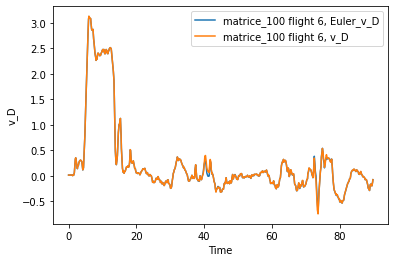

In [8]:
plotflight(temp_df, [6], ['Euler_v_D'], min_t=0, max_t=600)
plotflight(df_m100, [6], ['v_D'], min_t=0, max_t=600)

The graph above shows the velocity for 2 different flights. However, there are errors in the velocity due to conversion between Euler and quaternion as shown in flight 3. Therefore, it is best to apply rotation matrix directly using quaternion.

### Standardizing Values

1. Acceleration $a_{D}$ is centralized at the gravitational constant $g = -9.81 m/s^{2}$. For other drones, the raw accelerometer is calibrated to $g=-1$. Therefore, scaling of $a_{D}$ by $\frac{1}{g}$ is done
2. Angular velocity $\omega_{x,y,z}$ has units of radians per second. For other drones,  $\omega_{x,y,z}$ is in degrees per second, thus multiply by $\frac{180^\circ}{\pi}$
3. Calculate wind speed
4. Rename the columns to specified name above and drop unused columns
5. Rename flight number for Matrice 100 in ascending order {0 to 208}.

Additional information:

1. Wind direction (as measured wrt North) takes $0^\circ \leq \theta \lt 360^\circ$. However, for Mavic Pro, the wind direction takes $-180^\circ \leq \theta \lt 180^\circ$ (as measured wrt North). No action required as sign is consistent when used with sine and cosine trignometric functions.

In [9]:
#calculate power
df_m100['battery_power'] = df_m100['battery_voltage'] * df_m100['battery_current']
#scale acceleration by 1/g
df_m100['a_D'] = df_m100['a_D'] / 9.81
#convert angular units
df_m100['angular_x'] = df_m100['angular_x'] * 180 / np.pi
df_m100['angular_y'] = df_m100['angular_y'] * 180 / np.pi
df_m100['angular_z'] = df_m100['angular_z'] * 180 / np.pi
#calculate wind
df_m100['wind_N'] = df_m100['wind_speed'] * np.cos(df_m100['wind_angle']*np.pi/180)
df_m100['wind_E'] = df_m100['wind_speed'] * np.sin(df_m100['wind_angle']*np.pi/180)

#rename columns
col_to_rename = {'position_x':'long',
                 'position_y':'lat',
                 'position_z':'alt'}
df_m100 = df_m100.rename(columns = col_to_rename)
#remove unused columns
df_m100 = df_m100.drop(['date',
                        'time_day',
                        'velocity_x',
                        'velocity_y', 
                        'velocity_z',
                        'linear_acceleration_x',
                        'linear_acceleration_y',
                        'linear_acceleration_z',
                        'orientation_x',
                        'orientation_y',
                        'orientation_z',
                        'orientation_w'], axis=1);
#rename flight no
flight_list = np.unique(df_m100['flight'])
new_flight_list = []
new_flight_no = 1
for flight in flight_list:
    temp_df = df_m100[df_m100['flight'] == flight]
    new_flight_list += temp_df.shape[0] * [new_flight_no]
    new_flight_no += 1
df_m100['flight'] = new_flight_list

### Filtering Noise

As evident from sample flights in the time graphs, the variance of measurement from raw sensors (power, acceleration, angular velocity) is high while the variance of calculated quantities (velocity) is low. The variance of power is due to fluctuation of voltage/current and also external noise. Therefore, moving average smoothing will be used to reduce the variance. Similarly, the other variables are also filtered using the same approach. As the accelerometer and battery data have different noise frequency, they have to be filtered separately.

This can be done using `uniform1dfilter` function from scipy packages. The arguments for the function are `size` which is the length of the filter and `mode` which will ensure that values at the edges of the sequence are continuous. Through trial and error, a filter size equal to the data frequency can be used to remove the high frequency noise in the data. **(2 Feb 2022 edit: The difference in frequency of data for Matrice 100 with other drone will lead to overfitting of complexity, thus make data frequency 1Hz also. For power, use size = 10. For acceleration, use size = 20. For wind and velocity, use size = 10)**

Alternatively, `median_filter` function can also be used. It works similar to the moving average filter, but takes the median value instead. This filter is commonly used in image processing to remove noise as a non-linear digital filtering. 

In [10]:
def moving_average_filter(dataframe, size, mode, param):
    """
    This function takes a dataframe, parameters to filter, 
    filter size and filter mode as argument. For each flight,
    calculate the moving average for every n-samples and 
    returns the filtered dataframe
    """
    filtered_df = dataframe.copy()
    for flight_no in np.unique(list(dataframe.flight)):
        for var in param:
            temp = dataframe[var][dataframe['flight'] == flight_no].copy()
            filtered_value = uniform_filter1d(temp, size = size, mode = mode)
            filtered_df.loc[temp.index, var] = filtered_value
    return filtered_df

def moving_median_filter(dataframe, size, mode, param):
    """
    This function takes a dataframe, parameters to filter, 
    filter size and filter mode as argument. For each flight,
    calculate the median for every n-samples and 
    returns the filtered dataframe
    """    
    filtered_df = dataframe.copy()
    for flight_no in np.unique(list(dataframe.flight)):
        for var in param:
            temp = dataframe[var][dataframe['flight'] == flight_no].copy()
            filtered_value = median_filter(temp, size = size, mode = mode)
            filtered_df.loc[temp.index, var] = filtered_value
    return filtered_df

In [11]:
#using average filter for power
size = 10
mode = 'nearest'
param = ['battery_power']
averaged_df_m100= moving_average_filter(df_m100, size, mode, param)

#using average filter for wind, velocity
size = 10
mode = 'nearest'
param = ['v_N', 'v_E', 'v_D', 'wind_N', 'wind_E']
averaged_df_m100=moving_average_filter(averaged_df_m100, size, mode, param)

#using average filter for IMU
size = 20
mode = 'nearest'
param = ['a_N', 'a_E', 'a_D']
averaged_df_m100=moving_average_filter(averaged_df_m100, size, mode, param)

#using median filter for power
size = 10
mode = 'nearest'
param = ['battery_power']
median_df_m100= moving_median_filter(df_m100, size, mode, param)

#using median filter for wind, velocity
size = 10
mode = 'nearest'
param = ['v_N', 'v_E', 'v_D', 'wind_N', 'wind_E']
median_df_m100=moving_median_filter(median_df_m100, size, mode, param)

#using median filter for IMU
size = 20
mode = 'nearest'
param = ['a_N', 'a_E', 'a_D']
median_df_m100=moving_median_filter(median_df_m100, size, mode, param)

### Comparing Filters

After applying the filters, the mean power using moving average filter remains unchanged while the mean power using median filter increased. In both filters, the variance of power was reduced. The decrease in variance is small because of the outlier at P=0 when t=0. From the graphs below, the high frequency noise have been removed. 

Both moving average and median filter produce similar results. Therefore, moving average filter will be used for pre-processing for other drone types.

One limitation of using the filter is that the magnitude of power peaks have been reduced after averaging effects. This may introduce additional errors when comparing with actual power. This may not be of concern if the goal of the model is to capture the trends of power with time.

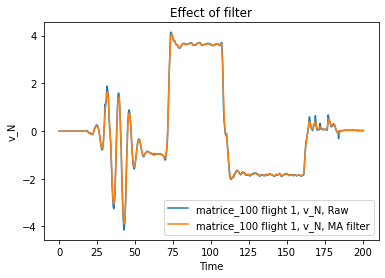

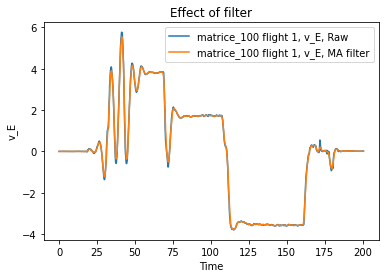

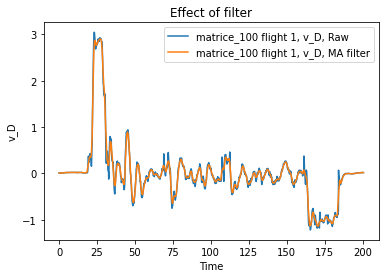

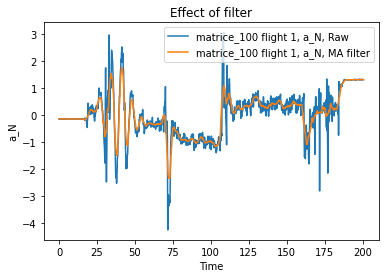

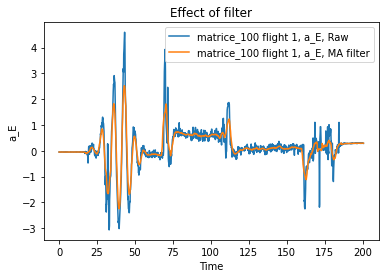

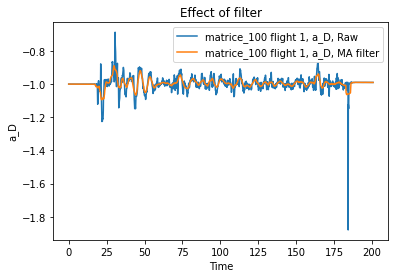

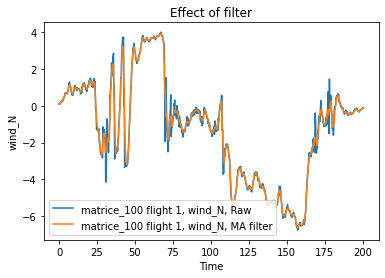

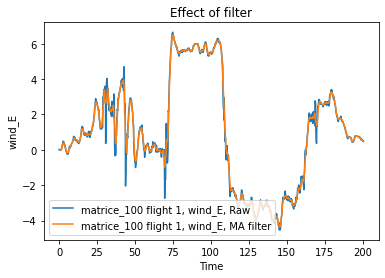

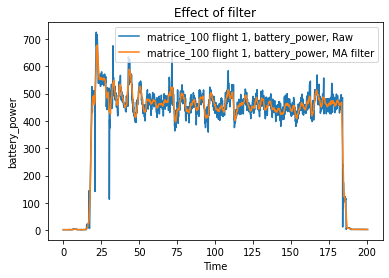

<Figure size 432x288 with 0 Axes>

In [12]:
for i in ['v_N', 'v_E', 'v_D', 'a_N', 'a_E', 'a_D', 'wind_N', 'wind_E', 'battery_power']:
    plotflight(df_m100, [1], [i], filterlabel = ', Raw', stats = False)
    plt.title('Effect of filter');
    plotflight(averaged_df_m100, [1], [i], filterlabel = ', MA filter', stats = False)
    plt.figure();

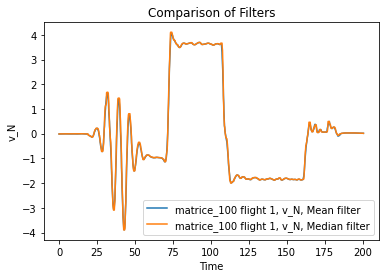

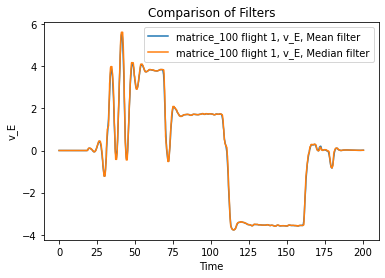

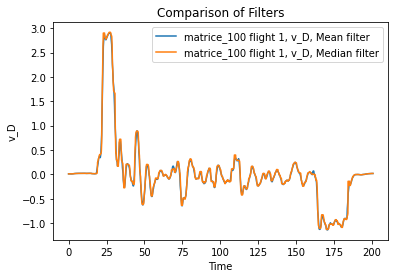

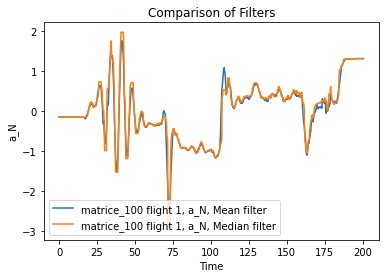

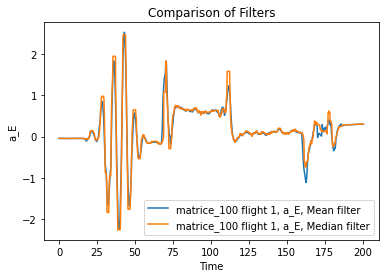

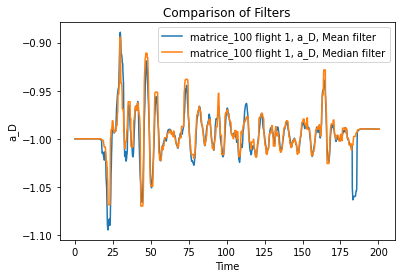

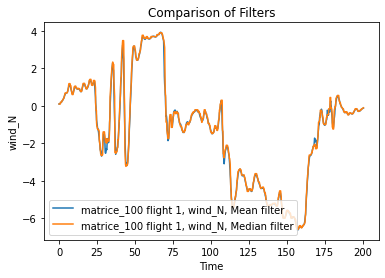

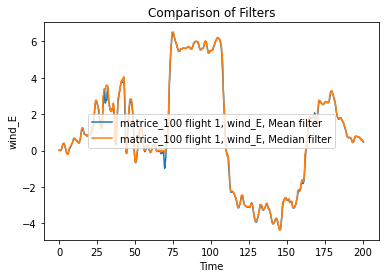

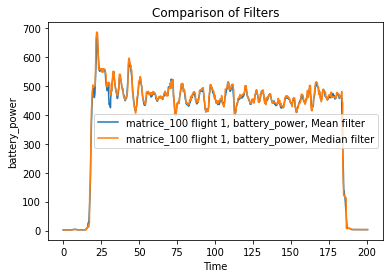

<Figure size 432x288 with 0 Axes>

In [13]:
for i in ['v_N', 'v_E', 'v_D', 'a_N', 'a_E', 'a_D', 'wind_N', 'wind_E', 'battery_power']:
    plotflight(averaged_df_m100, [1], [i], min_t=0, max_t=-1, filterlabel = ', Mean filter', stats = False)
    plt.title('Comparison of Filters');
    plotflight(median_df_m100, [1], [i], min_t=0, max_t=-1, filterlabel = ', Median filter', stats = False)
    plt.figure();

### Ground Power

When the drone is stationary on the ground, the power is close to zero. However, the other dynamic variables are non-zero and could affect the model prediction. Therefore, to remove the noise of ground power, set all dynamic variable to zero. 

In [14]:
var = ["v_N", "v_E", "v_D", "a_N", "a_E", "wind_N", "wind_E", "battery_power", 
       "wind_speed", "wind_angle", "angular_x", "angular_y", "angular_z", "battery_current", "battery_voltage"]
temp = averaged_df_m100[averaged_df_m100['battery_power']<=100].copy()
averaged_df_m100.loc[temp[var].index, var] = 0
averaged_df_m100.loc[temp['a_D'].index, 'a_D'] = -1

matrice_100 flight 1 battery_power mean: 388.94
matrice_100 flight 1 battery_power std: 177.27
matrice_100 flight 55 battery_power mean: 383.79
matrice_100 flight 55 battery_power std: 218.43
matrice_100 flight 78 battery_power mean: 376.86
matrice_100 flight 78 battery_power std: 233.35


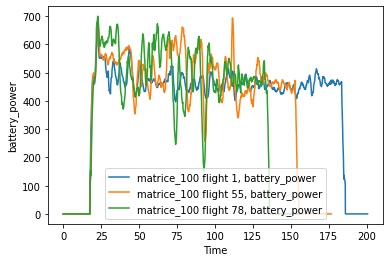

In [15]:
plotflight(averaged_df_m100, [1,55,78], ['battery_power'])

### Resampling Data

After applying the moving average filter over 1 second, the data frequency must be reduced to 1Hz in order to match with other drone type for prediction. Resampling on the dataframe is performed to reduce the sampling rate.

The `downsampling` function takes n row of a dataframe at regular intervals and skip unwanted rows. For instance, for n = 2 and s = [1,2,3,4,5,6,7,8,9] then s[::2] will return [1,3,5,7,9]. But if n = 3, then s[::3] will return [1,4,7]. If size of s is exactly divisible by n, combine the last row so that last element removed from slicing is included, i.e [1,4,7,9].

In [16]:
def downsampling(dataframe, n):
    """
    This function takes the dataframe and sample frequency n. For every 
    flight, take t = 1 followed by t = 1 + n, then t = 1 + 2n and so on.
    Returns sampled dataframe. 
    Note: This method does not interpolate/extrapolate any values.
    """
    sampled_df = pd.DataFrame()
    for flight_no in np.unique(list(dataframe.flight)):
            temp = dataframe[dataframe['flight'] == flight_no].copy()
            if temp.shape[0] % n == 0: #include last row
                temp2 = pd.concat([temp.loc[::n,:],temp.tail(1)])
            else:
                temp2 = temp.loc[::n,:]
            sampled_df = pd.concat([sampled_df, temp2], ignore_index=True)
    return sampled_df

In [17]:
sampled_df_m100 = downsampling(averaged_df_m100, 5)
print(f'shape of dataframe: {sampled_df_m100.shape}')
#display(Latex(sampled_df_m100.head(n=5).to_latex(columns=print_col)))
sampled_df_m100.head(n=5)

shape of dataframe: (51703, 30)


,flight,time,wind_speed,wind_angle,battery_voltage,battery_current,long,lat,alt,angular_x,...,psi,v_N,v_E,v_D,a_N,a_E,a_D,battery_power,wind_N,wind_E
0,1,0.00,0.0,0,0.0,0.0,-79.782396,40.458047,269.332402,0.0,...,-0.516789,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0
1,1,0.81,0.0,0,0.0,0.0,-79.782396,40.458047,269.335937,0.0,...,-0.516782,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0
2,1,1.50,0.0,0,0.0,0.0,-79.782397,40.458047,269.332274,0.0,...,-0.516757,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0
3,1,2.30,0.0,0,0.0,0.0,-79.782397,40.458047,269.331324,0.0,...,-0.516745,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0
4,1,3.00,0.0,0,0.0,0.0,-79.782397,40.458048,269.330575,0.0,...,-0.516732,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0


## Matrice 600

Basic information from [dji.com](https://dl.djicdn.com/downloads/m600%20pro/1208EN/Matrice_600_User_Manual_v1.0_EN_1208.pdf):

1. Total mass of drone is 9.1 kg
2. A3 flight control system has 3 GPS and IMU for triple modular redundancy. 
3. Data frequency for IMU, GPS and battery is 200 Hz, 5 Hz and 1 Hz respectively. 

There are two complete flight data for Matrice 600, flight number `071` and `072`. The data retrieved from `IMU_ATTI` is the quantity computer by flight controller using accelerometer, gyro and GPS. The Matrice 600 has triple redundancy, which means there are three sets of value for every quantity. The main purpose of redundancy IMU is to allow detection of faulty measurement in any module [(Bancroft, 2011)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3231672/). 

In theory, the accuracy of measurement should increase with redundancy but is affected by noise. Unfortunately, there are no information from the controller about which set of `IMU_ATTI` values were used in the actual flight. Hence, only data from `IMU_ATTI(0)` will be used and ignoring `IMU_ATTI(1)` and `IMU_ATTI(2)`. It is also possible to take the mean of all three IMU, but does not yield higher accuracy in doing so.

Additional information:

1. Wind speed and direction in NED must be calculated from body frame `AirSpeed:air_vbx:D` and `AirSpeed:air_vby:D`
2. Longitude and lattitude are missing
3. Current and voltage in milli Ampere and milli Volts
4. Acceleration $a_{D} = g = -1$

### Import Data

In [18]:
velocity = ['IMU_ATTI(0):velN', 'IMU_ATTI(0):velE', 'IMU_ATTI(0):velD']
acceleration = ['IMU_ATTI(0):accelX', 'IMU_ATTI(0):accelY', 'IMU_ATTI(0):accelZ']
position = ['IMU_ATTI(0):Longitude', 'IMU_ATTI(0):Latitude', 'IMU_ATTI(0):alti:D']
angular_velocity = ['IMU_ATTI(0):gyroX', 'IMU_ATTI(0):gyroY', 'IMU_ATTI(0):gyroZ']
orientation = ['IMU_ATTI(0):roll:C', 'IMU_ATTI(0):pitch:C', 'IMU_ATTI(0):yaw:C']
current = ['BatteryInfo:ave_I:D']
volt = ['BatteryInfo:pack_ve:D']
wind = ['AirSpeed:windSpeed','AirSpeed:windDirection']
time = ['Clock:offsetTime']
wind = ['AirSpeed:air_vbx:D', 'AirSpeed:air_vby:D']

flights = [71, 72]
df_m600 = pd.DataFrame()

for fl in flights:
    #load csv file
    raw_data = pd.read_csv('C:/Users/nghj7/Desktop/Flight data/Mavic Matrice 600/FLY'
                          +str(0)+str(fl)+'.csv');
    #create dataframe
    raw_df = pd.DataFrame(raw_data);
    #remove data with negative time step
    raw_df = raw_df[raw_df[time[0]] >= 0]
    #add flight number
    raw_df['flight'] = fl
    #concat
    df_m600 = pd.concat([df_m600, raw_df], ignore_index = True)

c:\users\nghj7\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3169: DtypeWarning: Columns (49,50,172,173,174,175,176,177,178,179,180,181,281,282,352,353,380,384,385,386,425) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
c:\users\nghj7\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3169: DtypeWarning: Columns (49,50,172,173,174,175,176,177,178,179,180,181,281,282,352,353,380,384,385,386,425) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Renaming Column

1. rename the columns to specified name above and drop unused columns
2. calculate battery power and total mass
3. calculate wind speed and map wind angle from $-180^{o}\leq \theta \leq 180^{o}$ to $0^{o}\leq \theta \leq 360^{o}$.
4. add name of drone column for referencing after concatenating
5. rename flight number of Matrice 600 to {300, 301}

In [19]:
col_to_rename = {velocity[0]:'v_N',
                 velocity[1]:'v_E',
                 velocity[2]:'v_D',
                 acceleration[0]:'a_N',
                 acceleration[1]:'a_E',
                 acceleration[2]:'a_D',
                 position[0]:'long',
                 position[1]:'lat',
                 position[2]:'alt',
                 angular_velocity[0]:'angular_x',
                 angular_velocity[1]:'angular_y',
                 angular_velocity[2]:'angular_z',
                 orientation[0]:'phi', 
                 orientation[1]:'theta',
                 orientation[2]:'psi',
                 current[0]:'battery_current',
                 volt[0]:'battery_voltage',
                 wind[0]:'wind_x',
                 wind[1]:'wind_y',
                 time[0]:'time'
}    

feature_to_keep = velocity + acceleration + position + angular_velocity + orientation + current + volt + wind + time + ['flight']
#drop unused columns
df_m600 = df_m600.drop(columns =[col for col in df_m600 if col not in feature_to_keep])
#rename cols
df_m600 = df_m600.rename(columns = col_to_rename)
#convert units
df_m600['battery_voltage'] = df_m600['battery_voltage'] / 1000
df_m600['battery_current'] = df_m600['battery_current'] / 1000
#calculate power
df_m600['battery_power'] = df_m600['battery_voltage'] * df_m600['battery_current']
#convert wind from body to NED
df_m600['wind_N'] = np.cos(df_m600['theta']*np.pi/180)*np.cos(df_m600['psi']*np.pi/180)*df_m600['wind_x'] + \
                 (np.sin(df_m600['phi']*np.pi/180)*np.sin(df_m600['theta']*np.pi/180)*np.cos(df_m600['psi']*np.pi/180) - np.cos(df_m600['phi']*np.pi/180)*np.sin(df_m600['psi']*np.pi/180))*df_m600['wind_y']
df_m600['wind_E'] = np.cos(df_m600['theta']*np.pi/180)*np.sin(df_m600['psi']*np.pi/180)*df_m600['wind_x'] + \
                 (np.sin(df_m600['phi']*np.pi/180)*np.sin(df_m600['theta']*np.pi/180)*np.sin(df_m600['psi']*np.pi/180) + np.cos(df_m600['phi']*np.pi/180)*np.cos(df_m600['psi']*np.pi/180))*df_m600['wind_y']
#change unique float -0 to 0 for arctan2
df_m600['wind_N'] = df_m600['wind_N'].map(lambda x: x if x != -0 else 0)
df_m600['wind_E'] = df_m600['wind_E'].map(lambda x: x if x != -0 else 0)
#calculate wind dir and angle
df_m600['wind_speed'] = np.sqrt(df_m600['wind_N']**2 +df_m600['wind_E']**2 )
df_m600['wind_angle'] = np.arctan2(df_m600['wind_E'], df_m600['wind_N'])*180/np.pi
df_m600['wind_angle'] = df_m600['wind_angle'].map(lambda x: x if x >= 0 else x + 360)
#drop unused columns
df_m600 = df_m600.drop(columns = ['wind_x', 'wind_y'])
#reset index
df_m600 = df_m600.reset_index(drop=True)
#payload
df_m600['payload'] = 0
#add total mass
df_m600['total_mass'] = 9.1 + df_m600['payload']  
#rename flight no
flight_list = np.unique(df_m600['flight'])
new_flight_list = []
new_flight_no = 300
for flight in flight_list:
    temp_df = df_m600[df_m600['flight'] == flight]
    new_flight_list += temp_df.shape[0] * [new_flight_no]
    new_flight_no += 1
df_m600['flight'] = new_flight_list
#add name of drone
df_m600['drone_type'] = 'matrice_600'
#display(Latex(df_m600.head(n=2).to_latex(columns=print_col)))
print('Shape of M600 data: ', df_m600.shape)
df_m600.head(n=5)

Shape of M600 data:  (230722, 27)


,time,long,lat,alt,phi,theta,psi,a_N,a_E,a_D,...,battery_voltage,flight,battery_power,wind_N,wind_E,wind_speed,wind_angle,payload,total_mass,drone_type
0,0.002,NaN,NaN,44.958057,1.793501,-1.896110,90.484404,-0.033567,-0.031171,-0.996974,...,52.207,300,26.558134,0.0,0.0,0.0,0.0,0,9.1,matrice_600
1,0.007,NaN,NaN,44.958057,1.793879,-1.896120,90.484310,-0.033587,-0.031254,-0.997028,...,52.207,300,26.558134,0.0,0.0,0.0,0.0,0,9.1,matrice_600
2,0.013,NaN,NaN,44.958057,1.793948,-1.895997,90.483891,-0.033357,-0.031545,-0.997077,...,52.207,300,26.558134,0.0,0.0,0.0,0.0,0,9.1,matrice_600
3,0.018,NaN,NaN,44.958057,1.794069,-1.895905,90.483446,-0.033048,-0.031594,-0.996987,...,52.207,300,26.558134,0.0,0.0,0.0,0.0,0,9.1,matrice_600
4,0.023,NaN,NaN,44.958057,1.794169,-1.896032,90.483152,-0.032743,-0.031465,-0.996954,...,52.207,300,26.558134,0.0,0.0,0.0,0.0,0,9.1,matrice_600


### Filtering Noise

In the time plot, the battery power resembles a step function while the other quantity resembles a general time signal. This is because the data logged by the IMU rate is 200 times faster than the battery rate. To train the machine learning model, it is desirable to remove the frequency differences between the dependent and independent variables. Similar to the open source data, the moving average smoothing for IMU data will be taken using `uniform1dfilter` function. The `size` of filter used will be 200. **(Edit: Regression tree shows that the noisy velocity data may lead to noisy power function. Added filter for velocity also.)**

In [20]:
#moving average for IMU data
param = ['a_N', 'a_E', 'a_D', 'v_N', 'v_E', 'v_D', 'wind_N', 'wind_E']
size = 200
mode = 'nearest'
averaged_df_m600 = moving_average_filter(df_m600, size, mode, param)

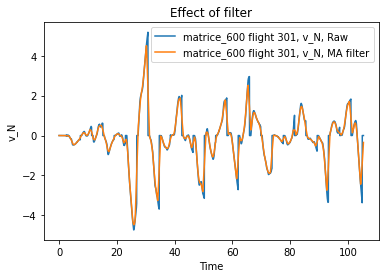

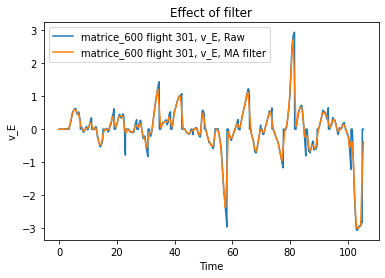

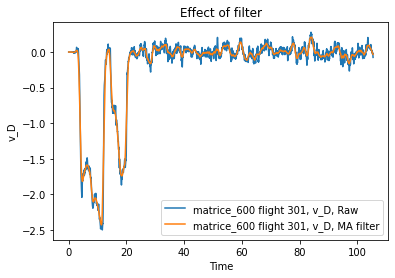

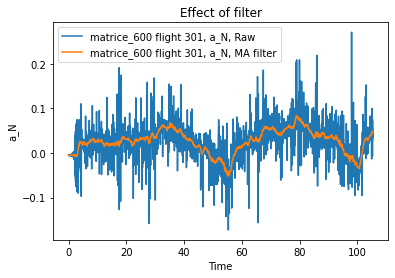

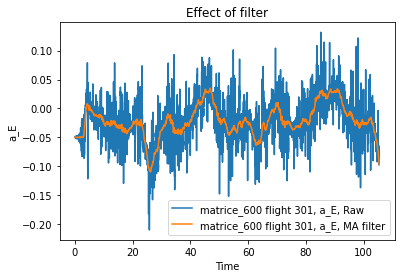

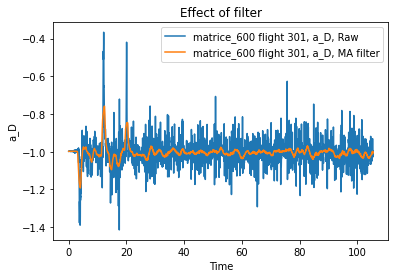

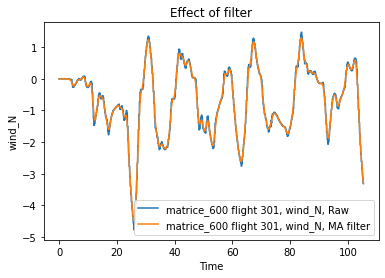

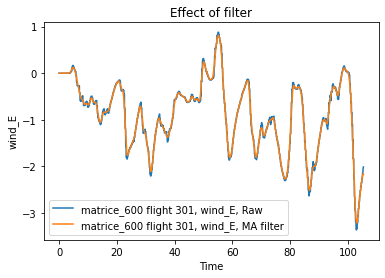

<Figure size 432x288 with 0 Axes>

In [21]:
for i in ['v_N', 'v_E', 'v_D', 'a_N', 'a_E', 'a_D', 'wind_N', 'wind_E']:
    plotflight(df_m600, [301], [i], max_t=20000, filterlabel = ', Raw', stats = False)
    plt.title('Effect of filter');
    plotflight(averaged_df_m600, [301], [i], max_t=20000, filterlabel = ', MA filter', stats = False)
    plt.figure();

### Ground Power

When the drone is stationary on the ground, the power is close to zero. However, the other dynamic variables are non-zero and could affect the model prediction. Therefore, to remove the noise of ground power, set all dynamic variable to zero. 

In [22]:
var = ["v_N", "v_E", "v_D", "a_N", "a_E", "wind_N", "wind_E", "battery_power", 
       "wind_speed", "wind_angle", "angular_x", "angular_y", "angular_z", "battery_current", "battery_voltage"]
temp = averaged_df_m600[averaged_df_m600['battery_power']<=200].copy()
averaged_df_m600.loc[temp[var].index, var] = 0
averaged_df_m600.loc[temp['a_D'].index, 'a_D'] = -1

matrice_600 flight 300 battery_power mean: 1001.63
matrice_600 flight 300 battery_power std: 161.19
matrice_600 flight 301 battery_power mean: 961.91
matrice_600 flight 301 battery_power std: 126.37


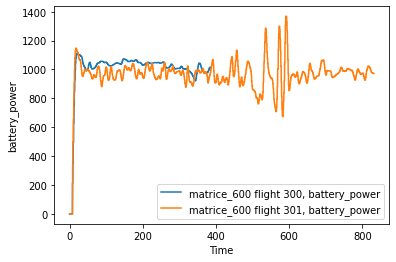

In [23]:
plotflight(averaged_df_m600, [300, 301], ['battery_power'])

### Resampling Data

After applying the moving average filter, the data frequency remains unchanged at 200Hz because 200 rows still correspond to 1 second. However, smoothing was applied over 200 rows of data or 1 second intervals. Thus, not all 200 rows are required to reconstruct the signal. Resampling on the dataframe is performed to reduce the sampling rate.

In [24]:
sampled_df_m600 = downsampling(averaged_df_m600, 200)
print(f'shape of dataframe: {sampled_df_m600.shape}')
#display(Latex(sampled_df_m600.head(n=5).to_latex(columns=print_col)))
sampled_df_m600.head(n=5)

shape of dataframe: (1155, 27)


,time,long,lat,alt,phi,theta,psi,a_N,a_E,a_D,...,battery_voltage,flight,battery_power,wind_N,wind_E,wind_speed,wind_angle,payload,total_mass,drone_type
0,0.002,NaN,NaN,44.958057,1.793501,-1.896110,90.484404,0.0,0.0,-1.0,...,0.0,300,0.0,0.0,0.0,0.0,0.0,0,9.1,matrice_600
1,1.062,NaN,NaN,44.958120,1.797885,-1.900274,90.365757,0.0,0.0,-1.0,...,0.0,300,0.0,0.0,0.0,0.0,0.0,0,9.1,matrice_600
2,2.122,NaN,NaN,44.965330,1.777286,-1.949924,90.449643,0.0,0.0,-1.0,...,0.0,300,0.0,0.0,0.0,0.0,0.0,0,9.1,matrice_600
3,3.183,NaN,NaN,45.000843,1.750084,-2.072969,90.593499,0.0,0.0,-1.0,...,0.0,300,0.0,0.0,0.0,0.0,0.0,0,9.1,matrice_600
4,4.240,NaN,NaN,45.114440,0.127454,-0.636263,90.161390,0.0,0.0,-1.0,...,0.0,300,0.0,0.0,0.0,0.0,0.0,0,9.1,matrice_600


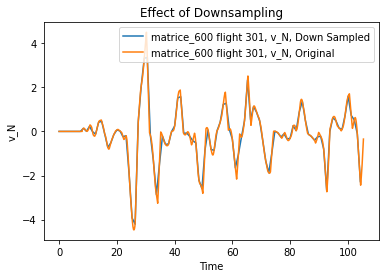

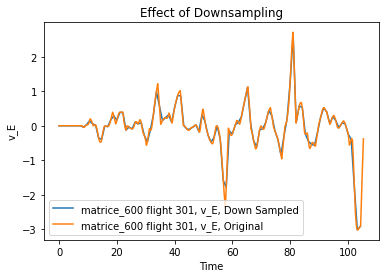

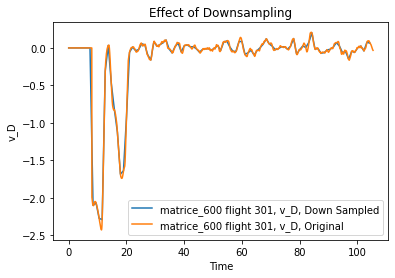

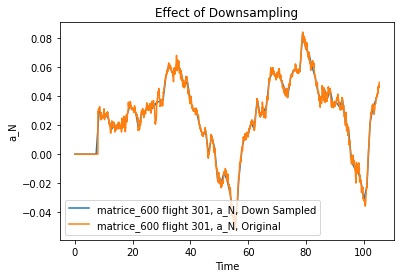

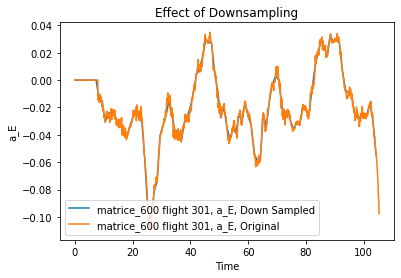

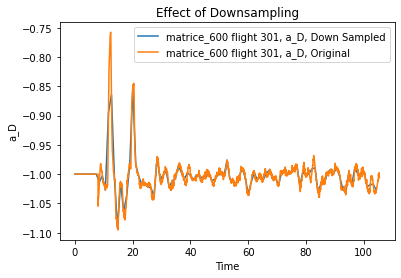

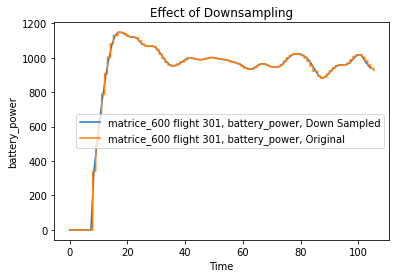

<Figure size 432x288 with 0 Axes>

In [25]:
for i in ['v_N', 'v_E', 'v_D', 'a_N', 'a_E', 'a_D', 'battery_power']:
    plotflight(sampled_df_m600, [301], [i], max_t=100, filterlabel = ', Down Sampled', stats = False)
    plt.title('Effect of Downsampling');
    plotflight(averaged_df_m600, [301], [i], max_t=20000, filterlabel = ', Original', stats = False)
    plt.figure();

## Mavic Pro

Basic information from [dji.com](https://www.dji.com/sg/mavic/info#specs):

1. Total mass of drone is 0.734 kg (excluding gimbal cover)
2. GPS and IMU sensor is single module only
3. Data frequency for IMU, GPS and battery is 200 Hz, 5 Hz and 1 Hz respectively. 

Additional information:

1. Current and voltage are in milli Ampere and milli Volts
2. Accelerometer in z-axis is $a_{z} = g = -1$
3. **Edit: Flight 332 has been removed from data.**

### Import Data

In [26]:
velocity = ['IMU_ATTI(0):velN', 'IMU_ATTI(0):velE', 'IMU_ATTI(0):velD']
acceleration = ['IMU_ATTI(0):accelX', 'IMU_ATTI(0):accelY', 'IMU_ATTI(0):accelZ']
position = ['IMU_ATTI(0):Longitude', 'IMU_ATTI(0):Latitude', 'IMU_ATTI(0):alti:D']
angular_velocity = ['IMU_ATTI(0):gyroX', 'IMU_ATTI(0):gyroY', 'IMU_ATTI(0):gyroZ']
orientation = ['IMU_ATTI(0):roll:C', 'IMU_ATTI(0):pitch:C', 'IMU_ATTI(0):yaw:C']
current = ['BatteryInfo:ave_I:D']
volt = ['BatteryInfo:pack_ve:D']
wind = ['AirSpeed:windSpeed','AirSpeed:windDirection']
time = ['Clock:offsetTime']

flights = [355, 372, 376]
df_mavic = pd.DataFrame()

for fl in flights:
    #load csv file
    raw_data = pd.read_csv('C:/Users/nghj7/Desktop/Flight data/Mavic Pro/FLY'
                          +str(fl)+'.csv');
    #create dataframe
    temp_df = pd.DataFrame(raw_data);
    #remove data with empty time steps
    temp_df =temp_df[temp_df[time[0]] >= 0]
    #add flight number
    temp_df['flight'] = fl
    #concat
    df_mavic = pd.concat([df_mavic, temp_df], ignore_index = True)

c:\users\nghj7\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3169: DtypeWarning: Columns (49,50,168,169,170,171,172,173,174,175,176,177,241,245,246,247,272) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
c:\users\nghj7\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3169: DtypeWarning: Columns (49,50,119,168,169,170,171,172,173,174,175,176,177,241,245,246,247,272) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
c:\users\nghj7\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3169: DtypeWarning: Columns (49,50,168,169,170,171,172,173,174,175,176,177,241,245,246,247,272) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(co

### Renaming Columns

1. rename the columns to specified name above and drop unused columns
2. calculate battery power and total mass
3. calculate wind speed and map wind angle from $-180^{o}\leq \theta \leq 180^{o}$ to $0^{o}\leq \theta \leq 360^{o}$
4. add name of drone column for referencing after concatenating
5. rename flight number of Mavic to {400 to 403}

In [27]:
col_to_rename = {velocity[0]:'v_N',
                 velocity[1]:'v_E',
                 velocity[2]:'v_D',
                 acceleration[0]:'a_N',
                 acceleration[1]:'a_E',
                 acceleration[2]:'a_D',
                 position[0]:'long',
                 position[1]:'lat',
                 position[2]:'alt',
                 angular_velocity[0]:'angular_x',
                 angular_velocity[1]:'angular_y',
                 angular_velocity[2]:'angular_z',
                 orientation[0]:'phi', 
                 orientation[1]:'theta',
                 orientation[2]:'psi',
                 current[0]:'battery_current',
                 volt[0]:'battery_voltage',
                 wind[0]:'wind_speed',
                 wind[1]:'wind_angle',
                 time[0]:'time'
}   

feature_to_keep = velocity + acceleration + position + angular_velocity + orientation + current + volt + wind + time + ['flight']
#drop unused columns
df_mavic  = df_mavic.drop(columns =[col for col in df_mavic if col not in feature_to_keep])
#rename cols
df_mavic = df_mavic.rename(columns = col_to_rename)
#convert units
df_mavic['battery_voltage'] = df_mavic['battery_voltage'] / 1000
df_mavic['battery_current'] = df_mavic['battery_current'] / 1000
#calculate power
df_mavic['battery_power'] = df_mavic['battery_current'] * df_mavic['battery_voltage']
#calaculate wind speed
df_mavic['wind_N'] = df_mavic['wind_speed'] * np.cos(df_mavic['wind_angle']*np.pi/180)
df_mavic['wind_E'] = df_mavic['wind_speed'] * np.sin(df_mavic['wind_angle']*np.pi/180)
df_mavic['wind_angle'] = df_mavic['wind_angle'].map(lambda x: x if x >= 0 else x + 360)
#reset index
df_mavic = df_mavic.reset_index(drop=True)
#payload
df_mavic['payload'] = 0
#add total mass
df_mavic['total_mass'] = 0.734 + df_mavic['payload']  
#rename flight no
flight_list = np.unique(df_mavic['flight'])
new_flight_list = []
new_flight_no = 400
for flight in flight_list:
    temp_df = df_mavic[df_mavic['flight'] == flight]
    new_flight_list += temp_df.shape[0] * [new_flight_no]
    new_flight_no += 1
df_mavic['flight'] = new_flight_list
#add name of drone
df_mavic['drone_type'] = 'mavic'
#display(Latex(df_mavic.head(n=2).to_latex(columns=print_col)))
print('Shape of Mavic data: ', df_m600.shape)
df_mavic.head(n=5)

Shape of Mavic data:  (230722, 27)


,time,long,lat,alt,phi,theta,psi,a_N,a_E,a_D,...,wind_angle,battery_current,battery_voltage,flight,battery_power,wind_N,wind_E,payload,total_mass,drone_type
0,0.003,103.683224,1.346912,68.95275,-0.201366,0.439593,93.711540,0.005228,0.002459,-0.995804,...,0.0,1.212423,12.612,400,15.291078,0.0,0.0,0,0.734,mavic
1,0.008,103.683224,1.346912,68.95275,-0.201209,0.438908,93.710736,0.004312,0.003118,-0.995556,...,0.0,1.212423,12.612,400,15.291078,0.0,0.0,0,0.734,mavic
2,0.013,103.683224,1.346912,68.95275,-0.199506,0.436706,93.705900,0.005432,0.003499,-0.995413,...,0.0,1.212423,12.612,400,15.291078,0.0,0.0,0,0.734,mavic
3,0.018,103.683224,1.346912,68.95275,-0.198301,0.434852,93.703595,0.006679,0.003179,-0.995412,...,0.0,1.212423,12.612,400,15.291078,0.0,0.0,0,0.734,mavic
4,0.023,103.683224,1.346912,68.95275,-0.197802,0.433640,93.702117,0.007775,0.002672,-0.995543,...,0.0,1.212423,12.612,400,15.291078,0.0,0.0,0,0.734,mavic


### Filtering Noise

In [28]:
#moving average for IMU data
param = ['a_N', 'a_E', 'a_D', 'v_N', 'v_E', 'v_D', 'wind_N', 'wind_E']
size = 200
mode = 'nearest'
averaged_df_mavic = moving_average_filter(df_mavic, size, mode, param)

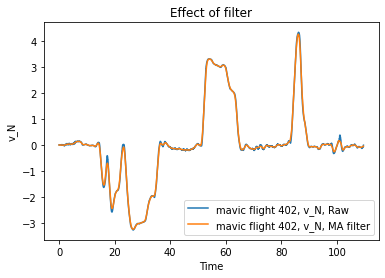

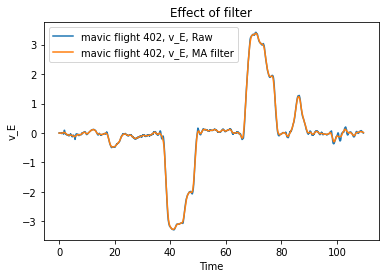

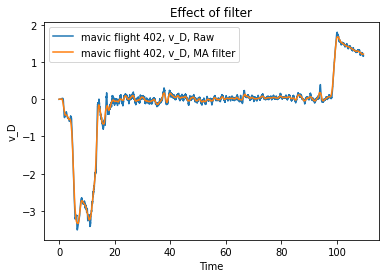

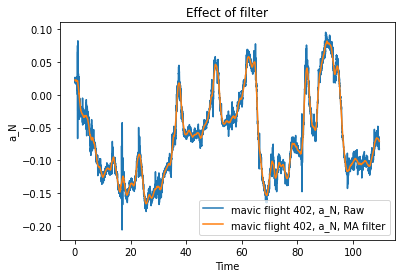

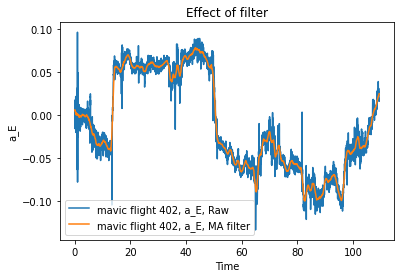

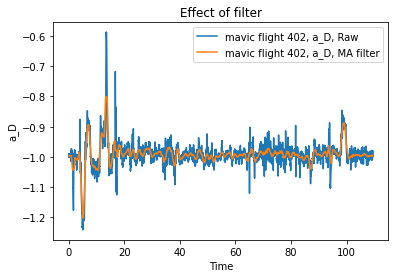

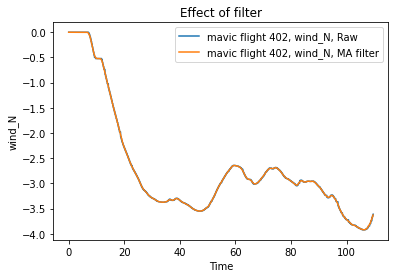

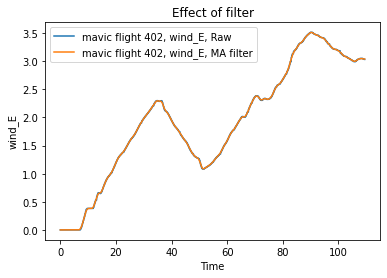

<Figure size 432x288 with 0 Axes>

In [29]:
for i in ['v_N', 'v_E', 'v_D', 'a_N', 'a_E', 'a_D', 'wind_N', 'wind_E']:
    plotflight(df_mavic, [402], [i], max_t=20000, filterlabel = ', Raw', stats = False)
    plt.title('Effect of filter');
    plotflight(averaged_df_mavic, [402], [i], max_t=20000, filterlabel = ', MA filter', stats = False)
    plt.figure();

### Ground Power

When the drone is stationary on the ground, the power is close to zero. However, the other dynamic variables are non-zero and could affect the model prediction. Therefore, to remove the noise of ground power, set all dynamic variable to zero. 

In [30]:
var = ["v_N", "v_E", "v_D", "a_N", "a_E", "wind_N", "wind_E", "battery_power", 
       "wind_speed", "wind_angle", "angular_x", "angular_y", "angular_z", "battery_current", "battery_voltage"]
temp = averaged_df_mavic[averaged_df_mavic['battery_power']<=40].copy()
averaged_df_mavic.loc[temp[var].index, var] = 0
averaged_df_mavic.loc[temp['a_D'].index, 'a_D'] = -1

mavic flight 400 battery_power mean: 58.40
mavic flight 400 battery_power std: 45.88
mavic flight 401 battery_power mean: 83.88
mavic flight 401 battery_power std: 25.12
mavic flight 402 battery_power mean: 85.20
mavic flight 402 battery_power std: 26.31


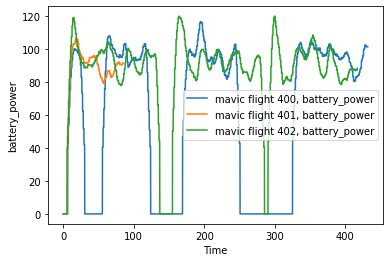

In [31]:
plotflight(averaged_df_mavic, [400, 401, 402], ['battery_power'], min_t=0, max_t=-1)

### Downsampling

In [32]:
#downsample 
sampled_df_mavic= downsampling(averaged_df_mavic, 200)
print(f'shape of dataframe: {sampled_df_mavic.shape}')
#display(Latex(sampled_df_mavic.head(n=5).to_latex(columns=print_col)))
sampled_df_mavic.head(n=5)

shape of dataframe: (847, 27)


,time,long,lat,alt,phi,theta,psi,a_N,a_E,a_D,...,wind_angle,battery_current,battery_voltage,flight,battery_power,wind_N,wind_E,payload,total_mass,drone_type
0,0.003,103.683224,1.346912,68.952750,-0.201366,0.439593,93.711540,0.0,0.0,-1.0,...,0.0,0.0,0.0,400,0.0,0.0,0.0,0,0.734,mavic
1,1.041,103.683224,1.346912,68.944030,-0.166299,0.386237,93.683250,0.0,0.0,-1.0,...,0.0,0.0,0.0,400,0.0,0.0,0.0,0,0.734,mavic
2,2.066,103.683224,1.346912,68.918625,-0.177493,0.413491,93.671817,0.0,0.0,-1.0,...,0.0,0.0,0.0,400,0.0,0.0,0.0,0,0.734,mavic
3,3.110,103.683224,1.346911,68.595200,0.307561,-2.064982,93.802051,0.0,0.0,-1.0,...,0.0,0.0,0.0,400,0.0,0.0,0.0,0,0.734,mavic
4,4.248,103.683225,1.346912,68.831410,1.770998,0.458477,93.899868,0.0,0.0,-1.0,...,0.0,0.0,0.0,400,0.0,0.0,0.0,0,0.734,mavic


## Inspire 1 

Basic information from  [dji.com](https://dl.djicdn.com/downloads/INSPIRE%201%20series/20201123/INSPIRE_1_V2.0_User_Manual_EN_20201123.pdf)

1. total mass of drone is 2.845kg (excluding camera)
2. GPS and IMU sensor is single module only
3. Data frequency for IMU, GPS and battery is 200 Hz, 5 Hz and 1 Hz respectively. 

Additional information:

1. The airspeed (wind speed and direction) are missing
2. Current and voltage are already in Ampere and Volts
3. Accelerometer in z-axis is $a_{z} = g = -1$

### Import Data

In [33]:
velocity = ['IMU_ATTI(0):velN', 'IMU_ATTI(0):velE', 'IMU_ATTI(0):velD']
acceleration = ['IMU_ATTI(0):accelX', 'IMU_ATTI(0):accelY', 'IMU_ATTI(0):accelZ']
position = ['IMU_ATTI(0):Longitude', 'IMU_ATTI(0):Latitude', 'IMU_ATTI(0):alti:D']
angular_velocity = ['IMU_ATTI(0):gyroX', 'IMU_ATTI(0):gyroY', 'IMU_ATTI(0):gyroZ']
orientation = ['IMU_ATTI(0):roll:C', 'IMU_ATTI(0):pitch:C', 'IMU_ATTI(0):yaw:C']
current = ['Battery(0):current']
volt = ['Battery(0):totalVolts']
time = ['Clock:offsetTime']

flights = [735, 737]
df_inspire = pd.DataFrame()

for fl in flights:
    #load csv file
    raw_data = pd.read_csv('C:/Users/nghj7/Desktop/Flight data/Inspire/FLY'
                          +str(fl)+'.csv');
    #create dataframe
    temp_df = pd.DataFrame(raw_data);
    #remove data with empty time steps
    temp_df =temp_df[temp_df[time[0]] >= 0]
    #add flight number
    temp_df['flight'] = fl
    #concat
    df_inspire = pd.concat([df_inspire, temp_df], ignore_index = True)

c:\users\nghj7\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3169: DtypeWarning: Columns (204) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
c:\users\nghj7\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3169: DtypeWarning: Columns (206) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Renaming Columns

1. rename the columns to specified name above and drop unused columns
2. calculate battery power and total mass
3. add name of drone column for referencing after concatenating
5. rename flight number of Inspire to {500, 501}

In [34]:
col_to_rename = {velocity[0]:'v_N',
                 velocity[1]:'v_E',
                 velocity[2]:'v_D',
                 acceleration[0]:'a_N',
                 acceleration[1]:'a_E',
                 acceleration[2]:'a_D',
                 position[0]:'long',
                 position[1]:'lat',
                 position[2]:'alt',
                 angular_velocity[0]:'angular_x',
                 angular_velocity[1]:'angular_y',
                 angular_velocity[2]:'angular_z',
                 orientation[0]:'phi', 
                 orientation[1]:'theta',
                 orientation[2]:'psi',
                 current[0]:'battery_current',
                 volt[0]:'battery_voltage',
                 time[0]:'time'
}   

feature_to_keep = velocity + acceleration + position + angular_velocity + orientation + current + volt + time + ['flight']
#drop unused columns
df_inspire  = df_inspire.drop(columns =[col for col in df_inspire  if col not in feature_to_keep])
#rename cols
df_inspire  = df_inspire.rename(columns = col_to_rename)
#reset index
df_inspire = df_inspire.reset_index(drop=True)
#add wind column
df_inspire['wind_speed'] = 0
df_inspire['wind_angle'] = 0
#calaculate wind speed
df_inspire['wind_N'] = df_inspire['wind_speed'] * np.cos(df_inspire['wind_angle']*np.pi/180)
df_inspire['wind_E'] = df_inspire['wind_speed'] * np.sin(df_inspire['wind_angle']*np.pi/180)
#calculate power
df_inspire['battery_power'] = df_inspire['battery_current'] * df_inspire['battery_voltage']
#payload
df_inspire['payload'] = 0
#add total mass
df_inspire['total_mass'] = 2.845 + df_inspire['payload']  
#rename flight no
flight_list = np.unique(df_inspire['flight'])
new_flight_list = []
new_flight_no = 500
for flight in flight_list:
    temp_df = df_inspire[df_inspire['flight'] == flight]
    new_flight_list += temp_df.shape[0] * [new_flight_no]
    new_flight_no += 1
df_inspire['flight'] = new_flight_list
#add name of drone
df_inspire['drone_type'] = 'inspire'
print('Shape of Inspire data: ', df_inspire.shape)
#display(Latex(df_inspire.head(n=2).to_latex(columns=print_col)))
df_inspire.head(n=5)

Shape of Inspire data:  (128409, 27)


,time,long,lat,alt,phi,theta,psi,a_N,a_E,a_D,...,battery_voltage,flight,wind_speed,wind_angle,wind_N,wind_E,battery_power,payload,total_mass,drone_type
0,0.003,103.683527,1.347149,86.257080,-1.005603,1.654862,-100.488595,0.028326,0.018359,-1.025335,...,23.689,500,0,0,0.0,0.0,20.13565,0,2.845,inspire
1,0.008,103.683527,1.347149,86.256935,-1.005458,1.654821,-100.488339,0.028033,0.015942,-1.028834,...,23.689,500,0,0,0.0,0.0,20.13565,0,2.845,inspire
2,0.013,103.683527,1.347149,86.256790,-1.005311,1.654788,-100.488020,0.026779,0.010782,-1.033404,...,23.689,500,0,0,0.0,0.0,20.13565,0,2.845,inspire
3,0.018,103.683527,1.347149,86.256645,-1.005118,1.654824,-100.487690,0.029033,0.007985,-1.035047,...,23.689,500,0,0,0.0,0.0,20.13565,0,2.845,inspire
4,0.023,103.683527,1.347149,86.256530,-1.005053,1.655010,-100.486910,0.030754,0.007530,-1.034756,...,23.689,500,0,0,0.0,0.0,20.13565,0,2.845,inspire


### Filtering Noise

In [35]:
#moving average for IMU data
param = ['a_N', 'a_E', 'a_D', 'v_N', 'v_E', 'v_D', 'wind_N', 'wind_E']
size = 200
mode = 'nearest'
averaged_df_inspire = moving_average_filter(df_inspire, size, mode, param)

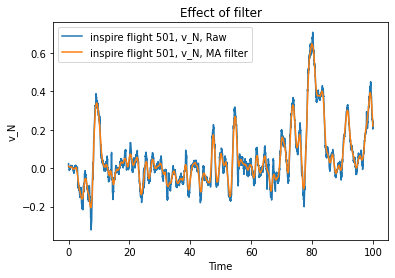

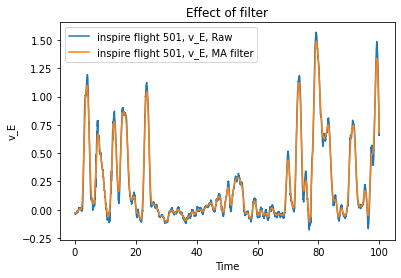

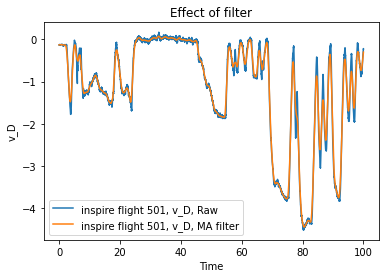

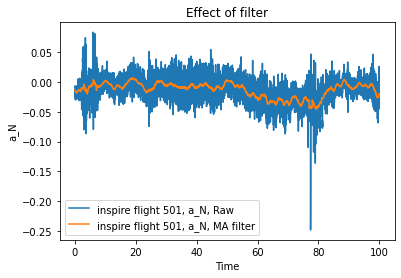

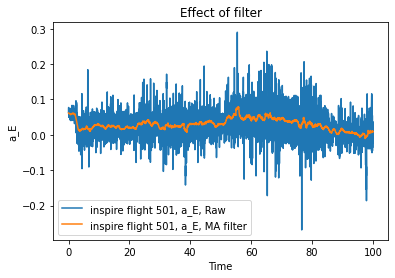

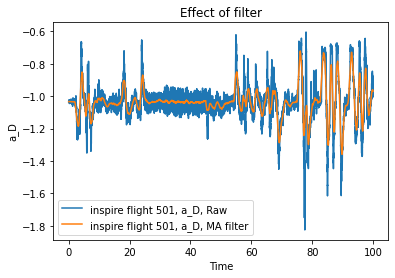

<Figure size 432x288 with 0 Axes>

In [36]:
for i in ['v_N', 'v_E', 'v_D', 'a_N', 'a_E', 'a_D']:
    plotflight(df_inspire, [501], [i], max_t=20000, filterlabel = ', Raw', stats = False)
    plt.title('Effect of filter');
    plotflight(averaged_df_inspire, [501], [i], max_t=20000, filterlabel = ', MA filter', stats = False)
    plt.figure();

### Ground Power

When the drone is stationary on the ground, the power is close to zero. However, the other dynamic variables are non-zero and could affect the model prediction. Therefore, to remove the noise of ground power, set all dynamic variable to zero. 

In [37]:
var = ["v_N", "v_E", "v_D", "a_N", "a_E", "wind_N", "wind_E", "battery_power", 
       "wind_speed", "wind_angle", "angular_x", "angular_y", "angular_z", "battery_current", "battery_voltage"]
temp = averaged_df_inspire[averaged_df_inspire['battery_power']<=200].copy()
averaged_df_inspire.loc[temp[var].index, var] = 0
averaged_df_inspire.loc[temp['a_D'].index, 'a_D'] = -1

inspire flight 500 battery_power mean: 356.20
inspire flight 500 battery_power std: 82.12
inspire flight 501 battery_power mean: 309.28
inspire flight 501 battery_power std: 141.81


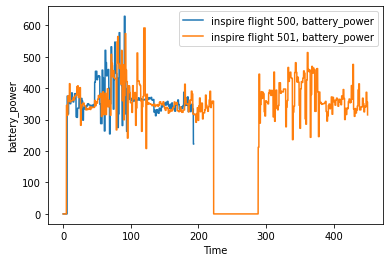

In [38]:
plotflight(averaged_df_inspire, [500, 501], ['battery_power'], min_t=0, max_t=-1)

### Downsampling

In [39]:
#downsample 
sampled_df_inspire= downsampling(averaged_df_inspire, 200)

print(f'shape of dataframe: {sampled_df_inspire.shape}')
#display(Latex(sampled_df_inspire.head(n=5).to_latex(columns=print_col)))
sampled_df_inspire.head(n=5)

shape of dataframe: (643, 27)


,time,long,lat,alt,phi,theta,psi,a_N,a_E,a_D,...,battery_voltage,flight,wind_speed,wind_angle,wind_N,wind_E,battery_power,payload,total_mass,drone_type
0,0.003,103.683527,1.347149,86.25708,-1.005603,1.654862,-100.488595,0.0,0.0,-1.0,...,0.0,500,0,0,0.0,0.0,0.0,0,2.845,inspire
1,1.003,103.683527,1.347149,86.26755,-1.006395,1.665726,-100.562483,0.0,0.0,-1.0,...,0.0,500,0,0,0.0,0.0,0.0,0,2.845,inspire
2,2.003,103.683527,1.347149,86.25441,-1.019783,1.598768,-100.499388,0.0,0.0,-1.0,...,0.0,500,0,0,0.0,0.0,0.0,0,2.845,inspire
3,3.003,103.683528,1.347150,86.25936,-1.004290,1.579808,-100.484844,0.0,0.0,-1.0,...,0.0,500,0,0,0.0,0.0,0.0,0,2.845,inspire
4,4.003,103.683528,1.347150,86.25688,-0.989048,1.548278,-100.592234,0.0,0.0,-1.0,...,0.0,500,0,0,0.0,0.0,0.0,0,2.845,inspire


## Merged dataset (Full)

In [40]:
merge_df = pd.concat([sampled_df_m100, sampled_df_m600, sampled_df_mavic, sampled_df_inspire], ignore_index = True)
merge_df = merge_df.fillna(0)
#check NaN cols
print('Total NaN count is :',merge_df.isnull().sum().sum())
#print shape
print(merge_df.shape)

Total NaN count is : 0
(54348, 30)


In [41]:
file_name = 'fulldata.csv'
merge_df.to_csv(file_name, encoding='utf-8', index=False)

## Filtered dataset (For Model)

In [42]:
pre_filtered_df = merge_df.copy()

#remove hover dataset
pre_filtered_df = pre_filtered_df[~pre_filtered_df['route'].isin(['H'])]

#rename flight no for matrice
temp_df = pre_filtered_df[pre_filtered_df['drone_type'] == 'matrice_100']
flight_list = np.unique(temp_df['flight'])
new_flight_list = []
new_flight_no = 1
for flight in flight_list:
    flight_len =temp_df[temp_df['flight'] == flight]
    new_flight_list += flight_len.shape[0] * [new_flight_no]
    new_flight_no += 1
pre_filtered_df.loc[temp_df.index, 'flight'] = new_flight_list
print('Shape of dataframe after removing hover set: ', pre_filtered_df.shape)

#training set
flight_list = [1, 55, 108, 145, 194] + [14, 59, 86, 96, 193] + [44, 56, 63, 67, 100] + [21] + [300, 301] + [400, 401, 402] + [500, 501]
filtered_df = pre_filtered_df[pre_filtered_df['flight'].isin(flight_list)]
print('Shape of dataframe after removing subset Matrice 100: ', filtered_df.shape)

#cols
column_to_keep = ['time','flight','drone_type','v_N','v_E','v_D','a_N','a_E','a_D','wind_N','wind_E','total_mass','battery_power',
                  'alt', 'long', 'lat', 'phi', 'theta', 'psi', 'angular_x', 'angular_y', 'angular_z', 'wind_speed', 'wind_angle']

filtered_df = filtered_df[column_to_keep]

Shape of dataframe after removing hover set:  (53587, 30)
Shape of dataframe after removing subset Matrice 100:  (6832, 30)


In [43]:
file_name = 'filtered_data.csv'
filtered_df.to_csv(file_name, encoding='utf-8', index=False)